<a href="https://colab.research.google.com/github/andrewshandy/Molecular_Properties_Prediction/blob/main/models/NF_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
!git clone https://github.com/gal-dmitry/NeuralFingerprint.git

Cloning into 'NeuralFingerprint'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 129 (delta 19), reused 104 (delta 6), pack-reused 0
Receiving objects: 100% (129/129), 3.90 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:33
🔁 Restarting kernel...


In [2]:
!mamba install -c conda-forge rdkit chembl_structure_pipeline


Streaming output truncated to the last 5000 lines.
pixman                   [] (00m:01s) Waiting...
pyparsing                [] (00m:01s) Waiting...
matplotlib-base          [] (00m:01s) Waiting...
reportlab                [] (00m:00s) Waiting...
pytz                     [] (00m:00s) Waiting...
xorg-libsm               [] (00m:00s) Waiting...
xorg-renderproto         [] (00m:00s) Waiting...
xorg-kbproto             [] (00m:00s) Waiting...
xorg-libxext             [] (00m:00s) Waiting...
xorg-xproto              [] (00m:00s) Waiting...
chembl_structure_pipelin [] (00m:00s) Waiting...
tornado                  [] (00m:00s) Waiting...
libcblas                 [] (00m:00s) Waiting...
jpeg                     [] (00m:00s) Waiting...
fontconfig               [] (00m:00s) Waiting...
gettext                  [] (00m:00s) Waiting...
liblapack                [] (00m:00s) Waiting...
libuuid                  [] (00m:00s) Waiting...
pandas                   [] (00m:00s)      4 MB /     12 MB (  2.74

In [3]:
import os, pickle
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
import matplotlib.pyplot as plt

sys.path.append('./NeuralFingerprint')



from neuralfingerprint import load_data, relu
from neuralfingerprint import build_conv_deep_net, build_convnet_fingerprint_fun
from neuralfingerprint import normalize_array, adam
from neuralfingerprint import build_batched_grad, degrees, build_standard_net
from neuralfingerprint.util import rmse
from neuralfingerprint.data_util import remove_duplicates

import pandas as pd

# Data loading

In [4]:
!wget https://www.dropbox.com/s/5b05tivi01a43np/delaney-processed.csv

--2021-05-09 20:26:44--  https://www.dropbox.com/s/5b05tivi01a43np/delaney-processed.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5b05tivi01a43np/delaney-processed.csv [following]
--2021-05-09 20:26:44--  https://www.dropbox.com/s/raw/5b05tivi01a43np/delaney-processed.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce94d34b2240d4e41691b61f127.dl.dropboxusercontent.com/cd/0/inline/BOLQpEhkYUCnRMHczOhOHXOejPm7iuPjFHrhSzXkrDKuB9sRAuVTJo6Kh5mmiYs0IYJLQ3Cq9RCAjjJf_m8AzcADHD3ta06YlfjPYaKY64uz9803bjFPGE8EdsMdrP4DQSUhcLuPivDJ3WkDcGQx9uC2/file# [following]
--2021-05-09 20:26:45--  https://uce94d34b2240d4e41691b61f127.dl.dropboxusercontent.com/cd/0/inline/BOLQpEhkYUCnRMHczOhOHXOejPm7iuPjFHrhSzXkrDKuB9sRAuVTJo6Kh5mmiYs

In [5]:
import pandas as pd
import os

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from typing import Dict, List, Optional
from pathlib import Path

from multiprocessing.pool import Pool

from rdkit.Chem.MolStandardize.tautomer import TautomerCanonicalizer

from multiprocessing.pool import Pool
from tqdm import tqdm

class DatasetsHolder:
    @staticmethod
    def read_datasets(inp_folder_path):
        df = pd.read_csv(inp_folder_path)
        return df
        # return pandas DataFrame


class StandardizeDatasets:
    @staticmethod
    def standardize_smiles(smi: str) -> Optional[str]:
        mol = Chem.MolFromSmiles(smi)
        mol = Chem.MolToSmiles(mol)
        return mol
        "crete typical standartization of one smiles"

    def standartize(self, inp_path: Path, out_path: Path):
        df_reader = DatasetsHolder()
        df = df_reader.read_datasets(inp_path)
        with Pool(10) as pool:
          df['standardize_smiles'] = list(
                      tqdm(pool.imap(self.standardize_smiles, df.smiles), total=df.shape[0])
                  )
        df.to_csv(out_path, index=False)
        return df
        "apply standartization to all smiles"


class StandardizeTautomers(StandardizeDatasets):
    @staticmethod
    def standardize_smiles(smi: str) -> Optional[str]:
        Canonicalizer = TautomerCanonicalizer()
        mol = Chem.MolFromSmiles(smi)
        standorized = Canonicalizer.canonicalize(mol)
        return Chem.MolToSmiles(standorized)

In [6]:
standartizer = StandardizeTautomers()

In [7]:
data_processed = standartizer.standartize('/content/delaney-processed.csv', 'standartize.csv')

100%|██████████| 1128/1128 [00:15<00:00, 75.16it/s]


In [8]:
data_processed

Compound ID  ...                                 standardize_smiles
0          Amigdalin  ...  N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1           Fenfuram  ...                             Cc1occc1C(=O)Nc1ccccc1
2             citral  ...                                 CC(C)=CCCC(C)=CC=O
3             Picene  ...                 c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4          Thiophene  ...                                            c1ccsc1
...              ...  ...                                                ...
1123       halothane  ...                                    FC(F)(F)C(Cl)Br
1124          Oxamyl  ...                          CNC(=O)ON=C(SC)C(=O)N(C)C
1125       Thiometon  ...                                  CCSCCSP(=S)(OC)OC
1126  2-Methylbutane  ...                                            CCC(C)C
1127        Stirofos  ...              COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl

[1128 rows x 11 columns]

# Initial Params

In [9]:
task_params = {'N_train': 1000,
               'N_valid': 50,
               'N_test': 78,
               'target_name' : 'measured log solubility in mols per litre',
               'data_file'   : '/content/standartize.csv'}


num_epochs = 50
batch_size = 64

normalize = 1
dropout = 0
activation = relu

params = {'fp_length': 100,
            'fp_depth': 5,
            'init_scale':np.exp(-4),
            'learn_rate': 0.001,
                    'b1':np.exp(-4),
                    'b2':np.exp(-4),
            'l2_penalty':np.exp(-5),
            'l1_penalty':np.exp(-4),
            'conv_width':20} 


conv_layer_sizes = [params['conv_width']] * params['fp_depth']
conv_arch_params = {'num_hidden_features' : conv_layer_sizes,
                    'fp_length' : params['fp_length'],
                    'normalize' : normalize,
                    'return_atom_activations':False}

all_radii = list(range(params['fp_depth'] + 1))



In [11]:
def parse_training_params(params):
    nn_train_params = {'num_epochs'  : num_epochs,
                       'batch_size'  : batch_size,
                       'learn_rate'  : params['learn_rate'],
                       'b1'          : params['b1'],
                       'b2'          : params['b2'],
                       'param_scale' : params['init_scale']}

    vanilla_net_params = {'layer_sizes':[params['fp_length']], 
                          'normalize':normalize,
                          'L2_reg': params['l2_penalty'],
                          'L1_reg': params['l1_penalty'],
                          'activation_function':activation}
    return nn_train_params, vanilla_net_params

In [12]:
def train_nn(pred_fun, loss_fun, num_weights, train_smiles, train_raw_targets, train_params,
             validation_smiles=None, validation_raw_targets=None):
    """loss_fun has inputs (weights, smiles, targets)"""
    print("Total number of weights in the network:", num_weights)
    npr.seed(0)
    init_weights = npr.randn(num_weights) * train_params['param_scale']

    train_targets, undo_norm = normalize_array(train_raw_targets)
    training_curve = []
    def callback(weights, iter):
        if iter % 10 == 0:
            print("max of weights", np.max(np.abs(weights)))
            train_preds = undo_norm(pred_fun(weights, train_smiles))
            cur_loss = loss_fun(weights, train_smiles, train_targets)
            training_curve.append(cur_loss)
            print("Iteration", iter) 
            print("loss", cur_loss, "train RMSE", np.sqrt(np.mean((train_preds - train_raw_targets)**2)), end=' ')
            if validation_smiles is not None:
                validation_preds = undo_norm(pred_fun(weights, validation_smiles))
                print("Valid. RMSE", iter, ":", \
                    np.sqrt(np.mean((validation_preds - validation_raw_targets) ** 2)), end=' ')
                    
    grad_fun = grad(loss_fun)
    grad_fun_with_data = build_batched_grad(grad_fun, train_params['batch_size'],
                                            train_smiles, train_targets)

    num_iters = train_params['num_epochs'] * len(train_smiles) // train_params['batch_size']


    trained_weights = adam(grad_fun_with_data, init_weights, callback=callback,
                           num_iters=num_iters, step_size=train_params['learn_rate'],
                           b1=train_params['b1'], b2=train_params['b2'])

    def predict_func(new_smiles):
        """Returns to the original units that the raw targets were in."""
        return undo_norm(pred_fun(trained_weights, new_smiles))
    return predict_func, trained_weights, training_curve

In [13]:
def train_neural_fingerprint():
    print("Loading data...")
    traindata, valdata, testdata = load_data(task_params['data_file'],
                        (task_params['N_train'], task_params['N_valid'], task_params['N_test']),
                        input_name='smiles', target_name=task_params['target_name'])
    train_inputs, train_targets = traindata
    val_inputs, val_targets = valdata
    
    print("Regression on", task_params['N_train'], "training points.")
    def print_performance(pred_func):
        train_preds = pred_func(train_inputs)
        val_preds = pred_func(val_inputs)
        print("\nPerformance (RMSE) on " + task_params['target_name'] + ":")
        print("Train:", rmse(train_preds, train_targets))
        print("Test: ", rmse(val_preds,  val_targets))
        print("-" * 80)
        return rmse(val_preds,  val_targets)

    print("-" * 80)
    print("Mean predictor")
    y_train_mean = np.mean(train_targets)
    print_performance(lambda x : y_train_mean)

    print("Task params", params)
    nn_train_params, vanilla_net_params = parse_training_params(params)
    conv_arch_params['return_atom_activations'] = False

    print("Convnet fingerprints with neural net")
    loss_fun, pred_fun, conv_parser = \
        build_conv_deep_net(conv_arch_params, vanilla_net_params, params['l2_penalty'])
    num_weights = len(conv_parser)
    predict_fun, trained_weights, conv_training_curve = \
        train_nn(pred_fun, loss_fun, num_weights, train_inputs, train_targets, nn_train_params, val_inputs, val_targets)
    print_performance(predict_fun)
    return trained_weights

# Train

In [14]:

trained_network_weights = train_neural_fingerprint()

Loading data...
Regression on 1000 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on measured log solubility in mols per litre:
Train: 2.1049631565020324
Test:  2.3171781852263758
--------------------------------------------------------------------------------
Task params {'fp_length': 100, 'fp_depth': 5, 'init_scale': 0.01831563888873418, 'learn_rate': 0.001, 'b1': 0.01831563888873418, 'b2': 0.01831563888873418, 'l2_penalty': 0.006737946999085467, 'l1_penalty': 0.01831563888873418, 'conv_width': 20}
Convnet fingerprints with neural net
Total number of weights in the network: 40481
max of weights 0.08535001578936458
Iteration 0
loss 1.445207171907361 train RMSE 2.5302908689483603 Valid. RMSE 0 : 2.6614064924098373 max of weights 0.09298203330179543
Iteration 10
loss 0.9024365558251847 train RMSE 1.9993700894322797 Valid. RMSE 10 : 2.2436033010876337 max of weights 0.09086614250204823
Iteration 20
loss

# Saving results 

In [26]:
with open('/content/model.pkl', 'wb') as f:
    pickle.dump(trained_network_weights, f)

# Visualization

In [27]:
def draw_molecule_with_highlights(filename, smiles, highlight_atoms):
    drawoptions = DrawingOptions()
    drawoptions.selectColor = highlight_color
    drawoptions.elemDict = {} 
    drawoptions.bgColor=None

    mol = Chem.MolFromSmiles(smiles)
    fig = Draw.MolToMPL(mol, highlightAtoms=highlight_atoms, size=figsize, options=drawoptions,fitImage=False)

    fig.gca().set_axis_off()
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)

In [28]:
def construct_atom_neighbor_list(array_rep):
    atom_neighbour_list = []
    for degree in degrees:
        atom_neighbour_list += [list(neighbours) for neighbours in array_rep[('atom_neighbors', degree)]]
    return atom_neighbour_list

In [29]:
# Plotting parameters
num_figs_per_fp = 11
figsize = (100, 100)
highlight_color = (30.0/255.0, 100.0/255.0, 255.0/255.0)  # A nice light blue.



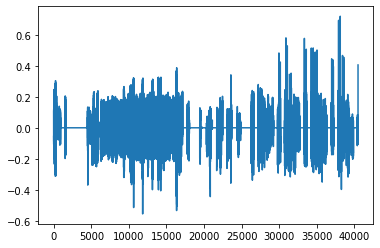

In [32]:
# Plotting.
with open('/content/model.pkl', 'rb') as f:
    trained_weights = pickle.load(f)
plt.plot(trained_weights)

In [33]:
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import warnings

warnings.filterwarnings('ignore')

In [34]:
class PhotoDataset(Dataset):
    def __init__(self, path_to_dataset):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return image
    
    def __len__(self):
        return len(self.photo_names)

In [35]:
def visualize(each_eleven):
    fig = plt.figure(figsize=(16, 5))
    columns = 6
    rows = 2
    title = 'Fingerprint_' + str(each_eleven)
    fig.suptitle(title, fontsize=16)

    ax = []
    for i in range(11):
        
        img = dataset[(i) + each_eleven*11]
        ax.append( fig.add_subplot(rows, columns, i+1) )
        plt.imshow(img)
        plt.axis('off') 

    plt.tight_layout()

In [38]:
dataset = PhotoDataset("/content/NeuralFingerprint/figures_SAMPL_jpg")

In [39]:
len(dataset)

550

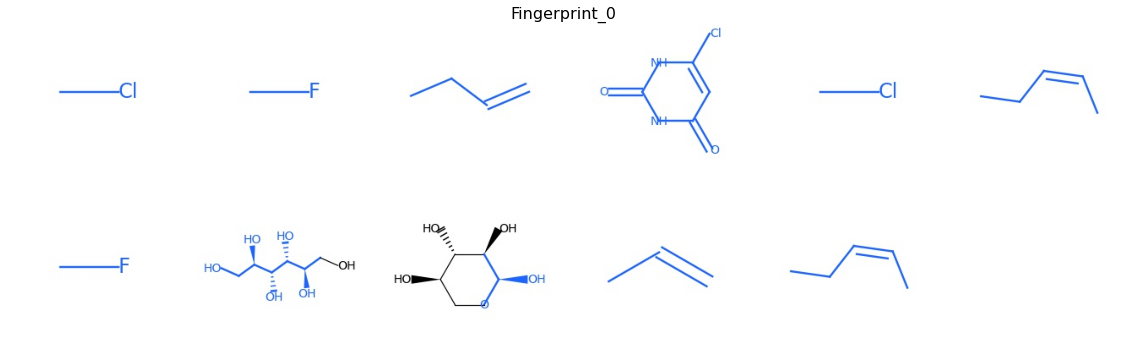

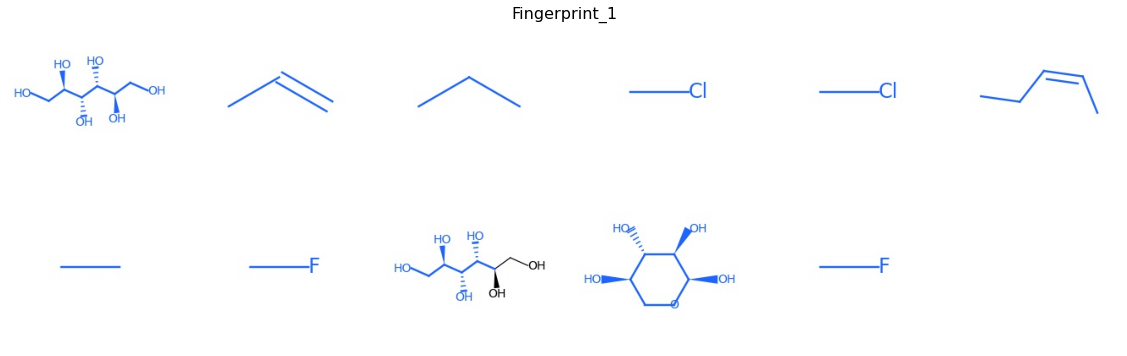

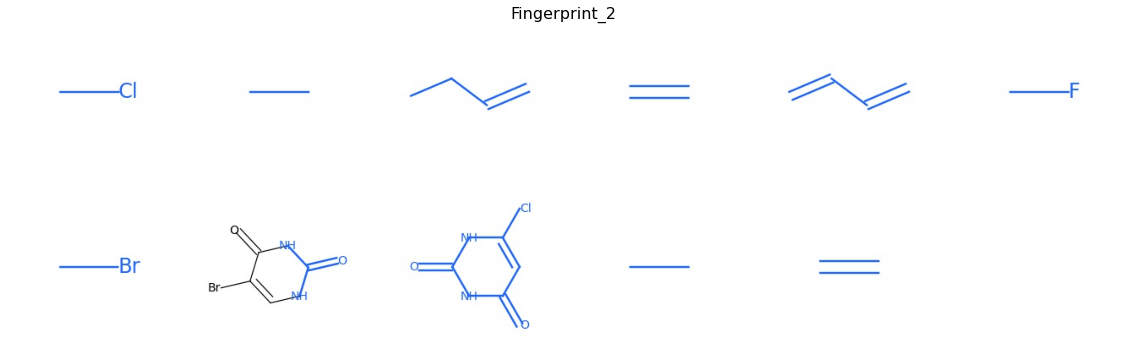

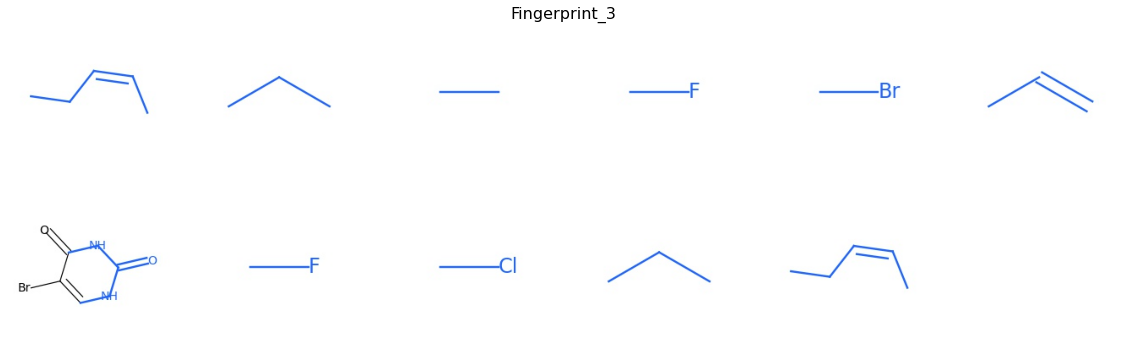

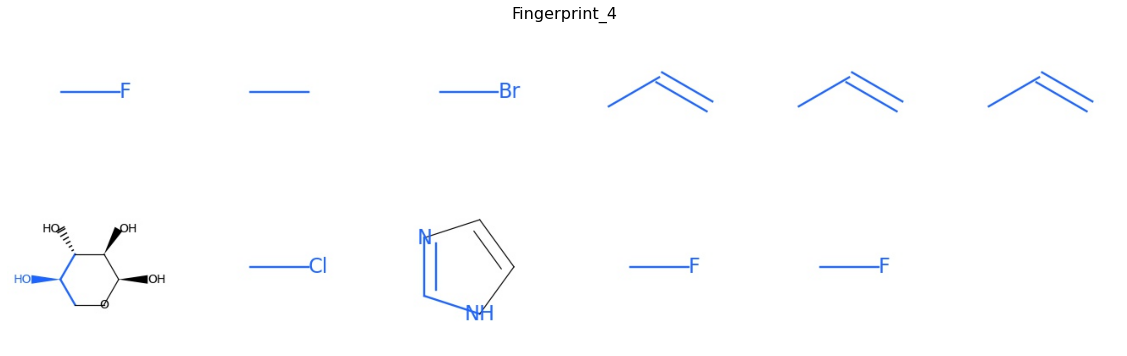

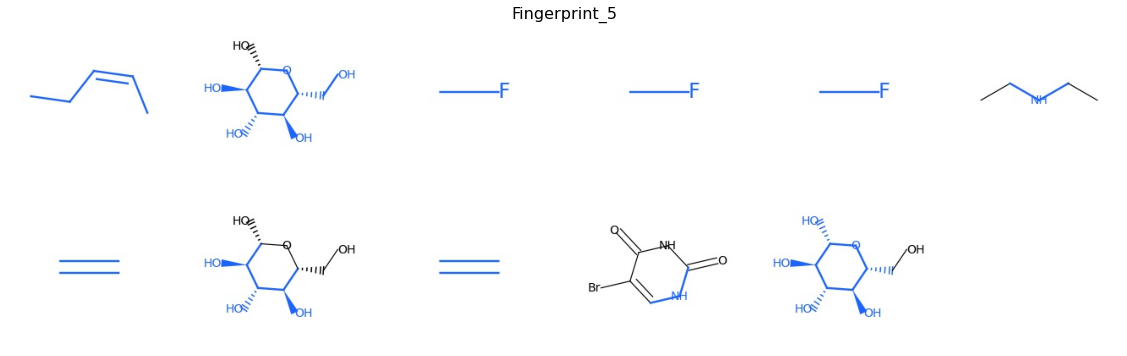

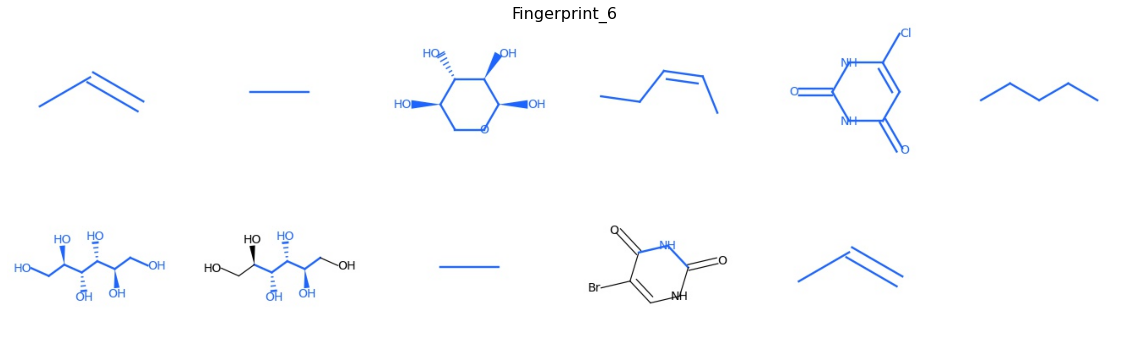

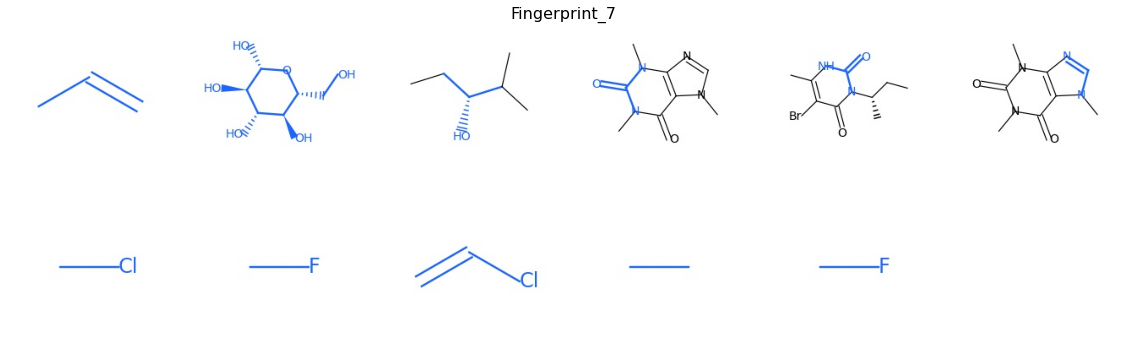

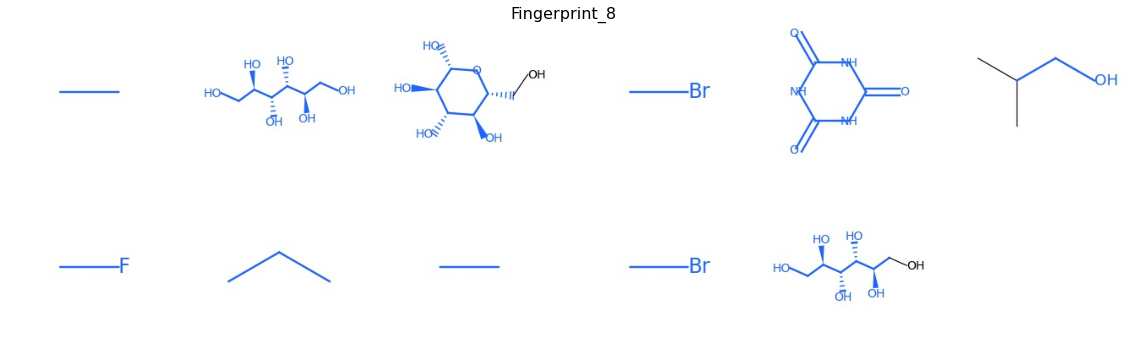

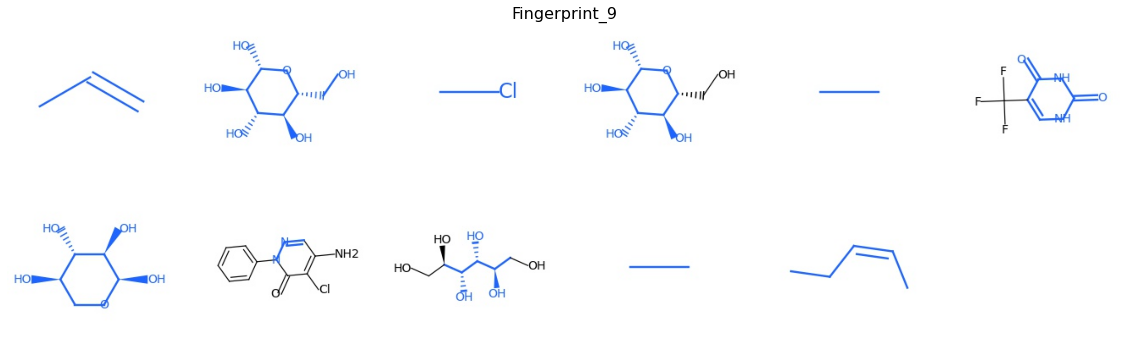

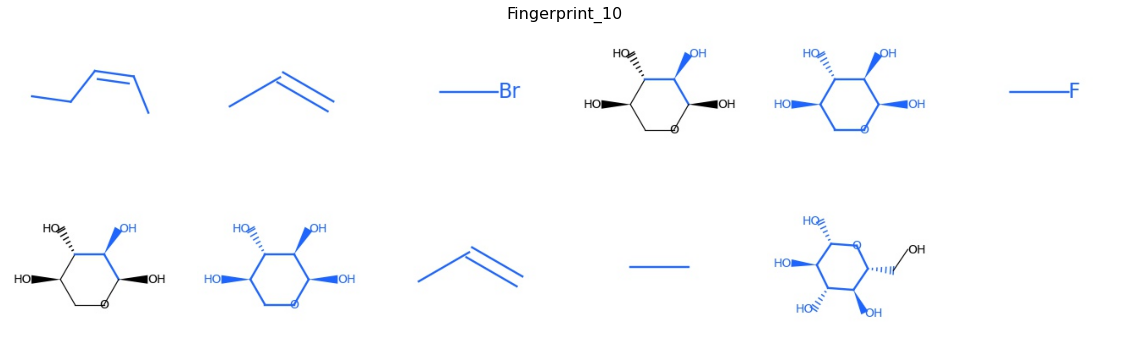

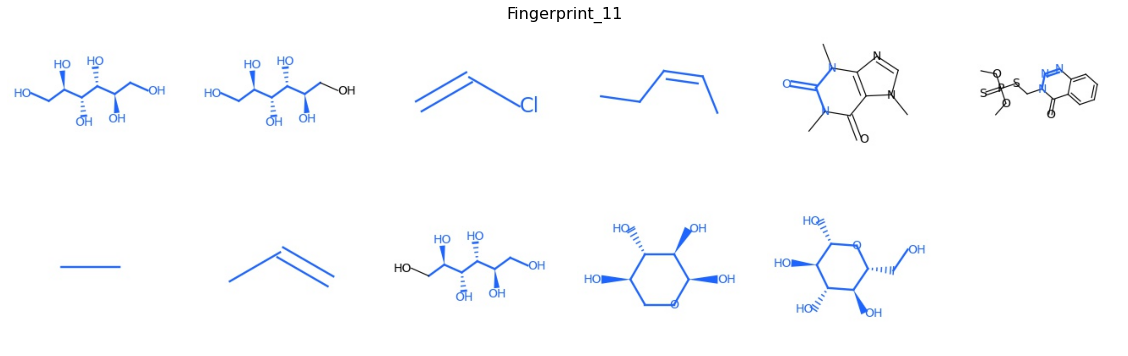

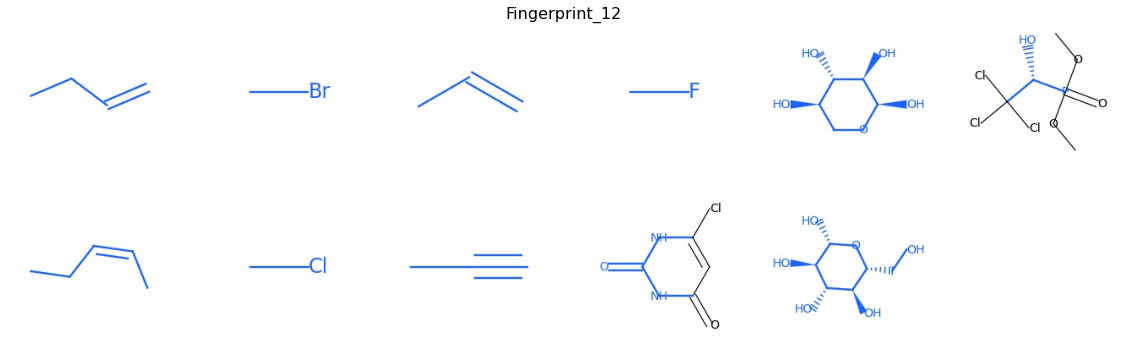

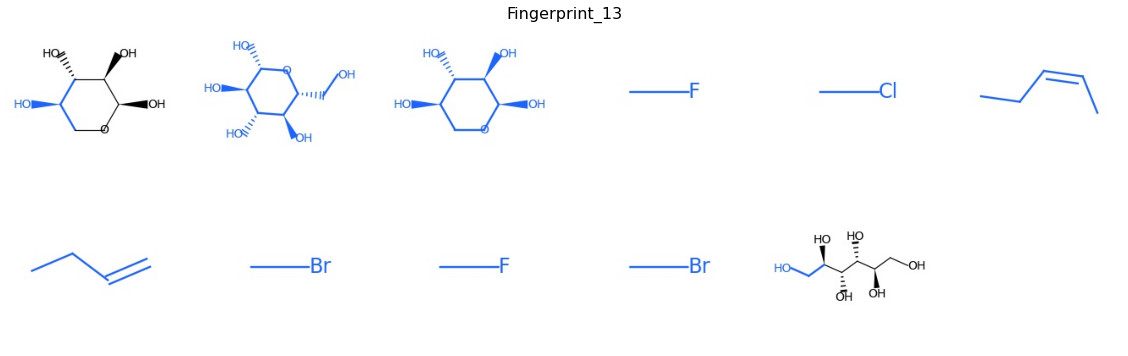

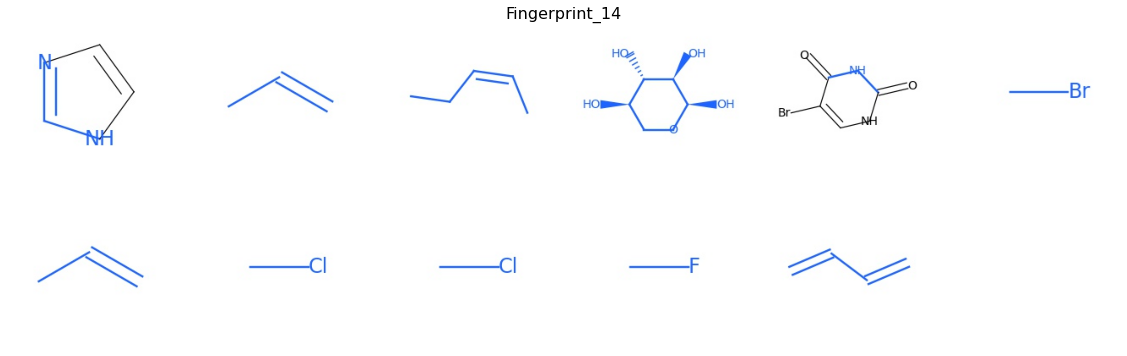

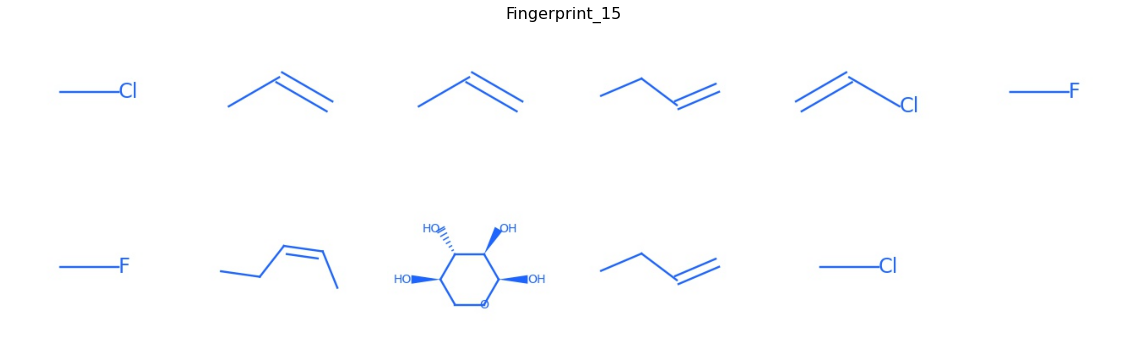

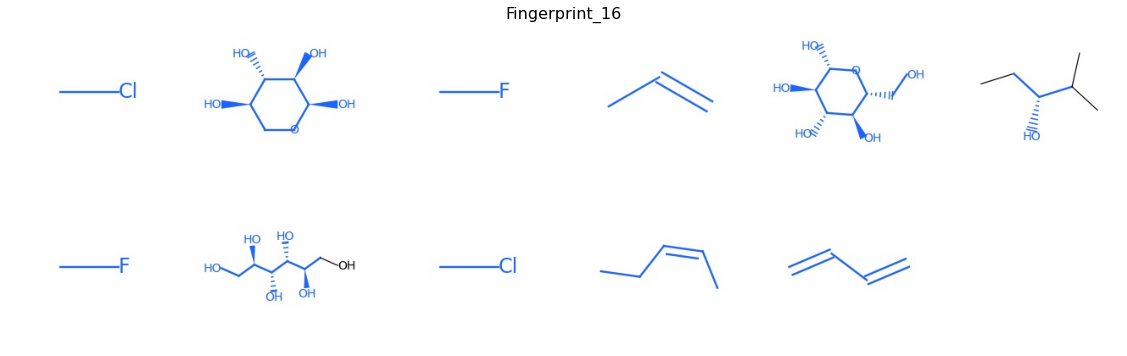

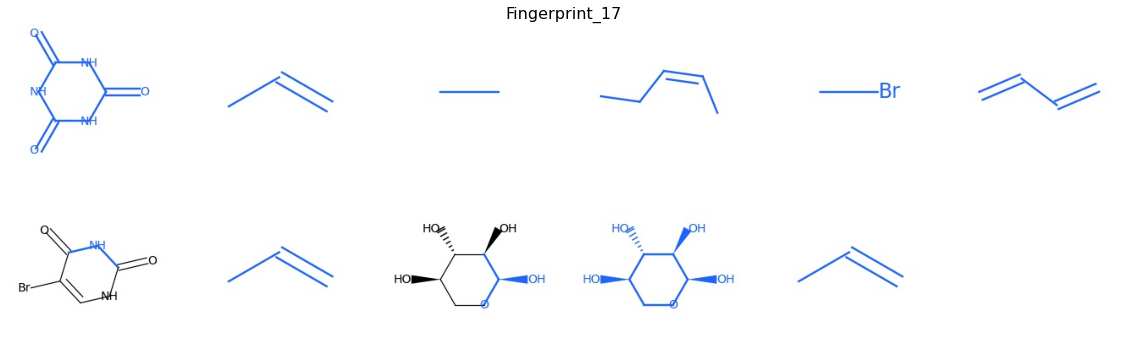

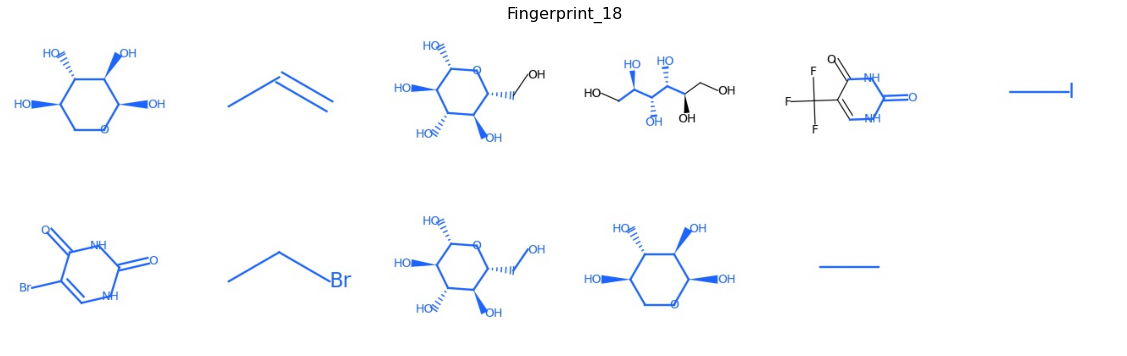

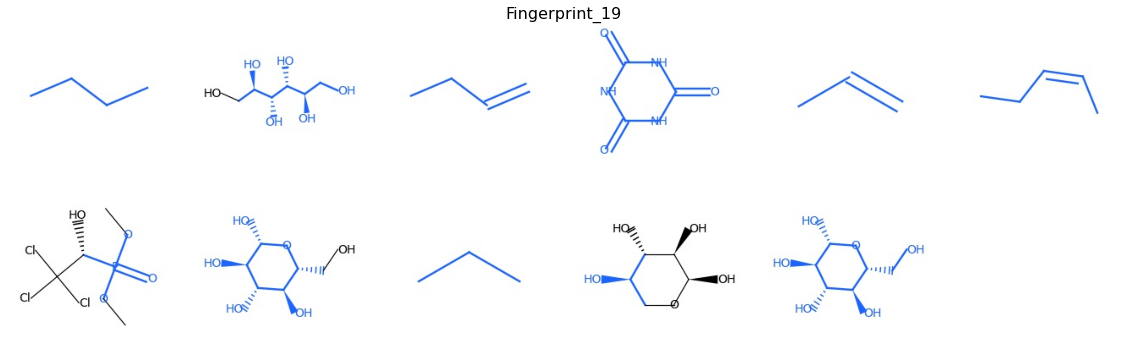

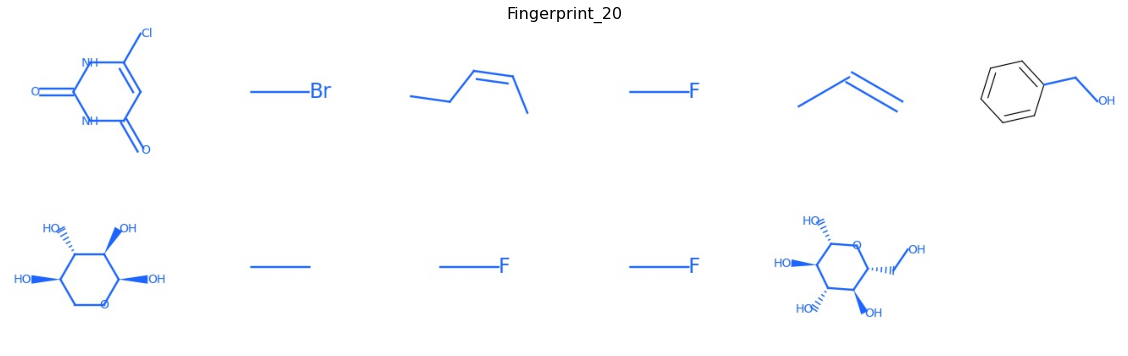

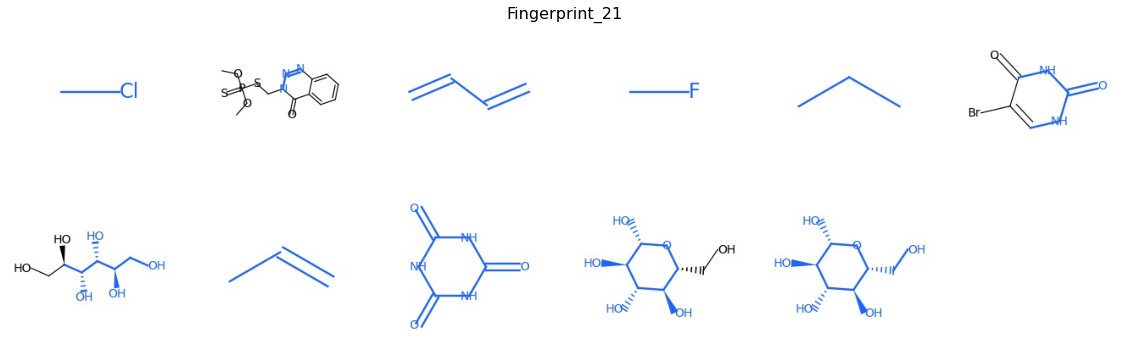

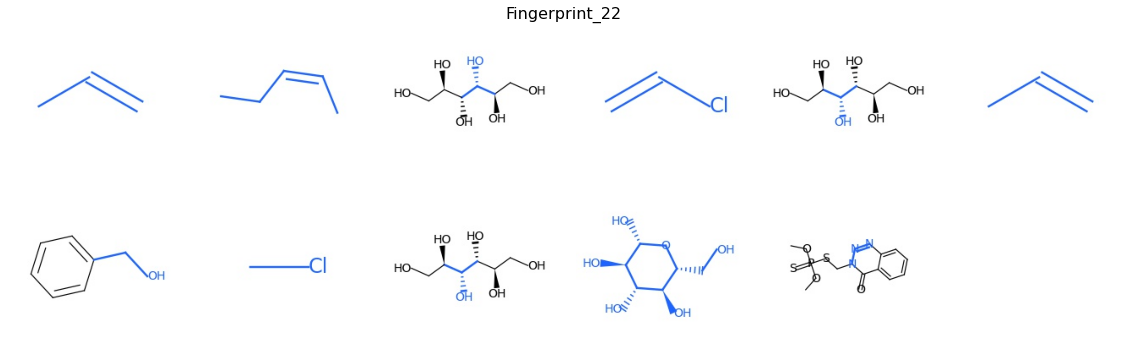

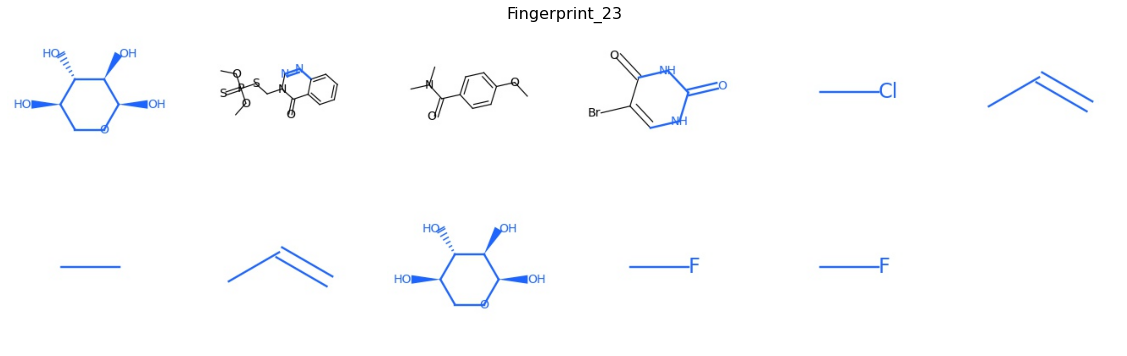

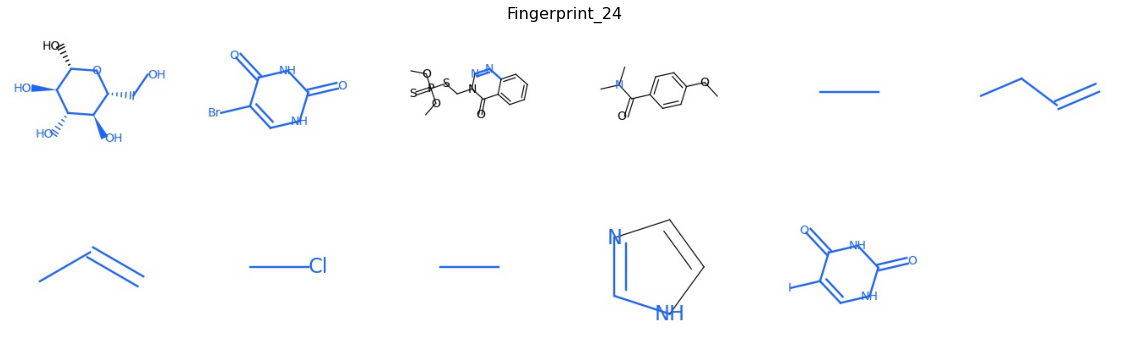

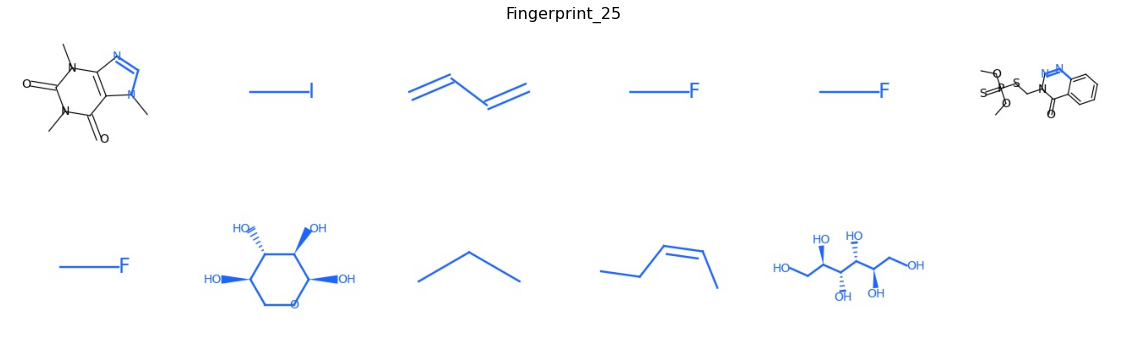

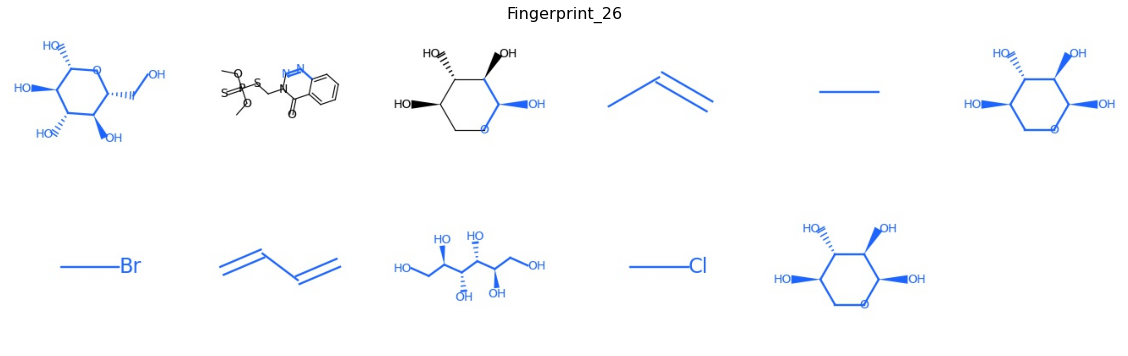

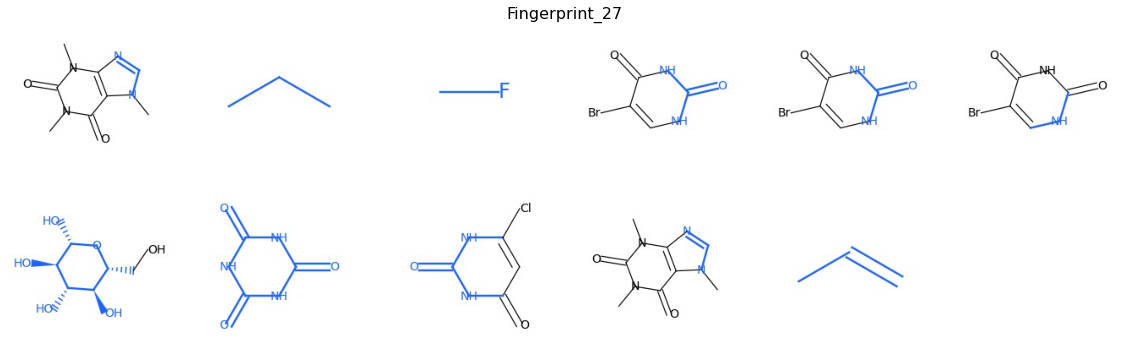

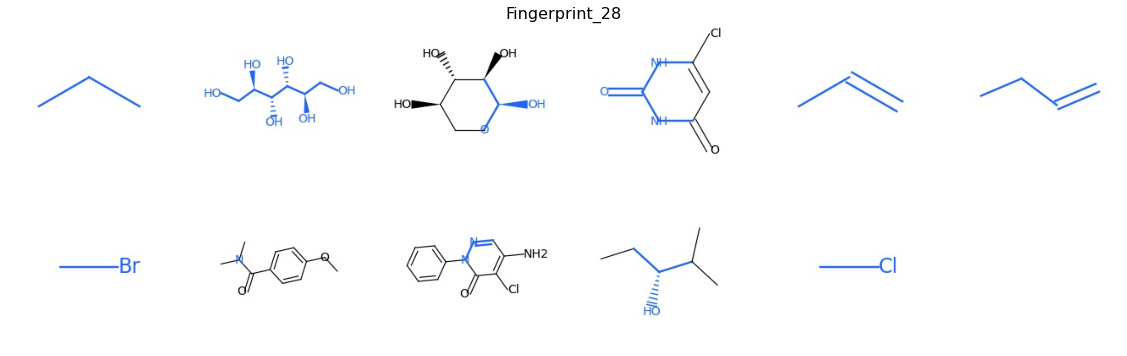

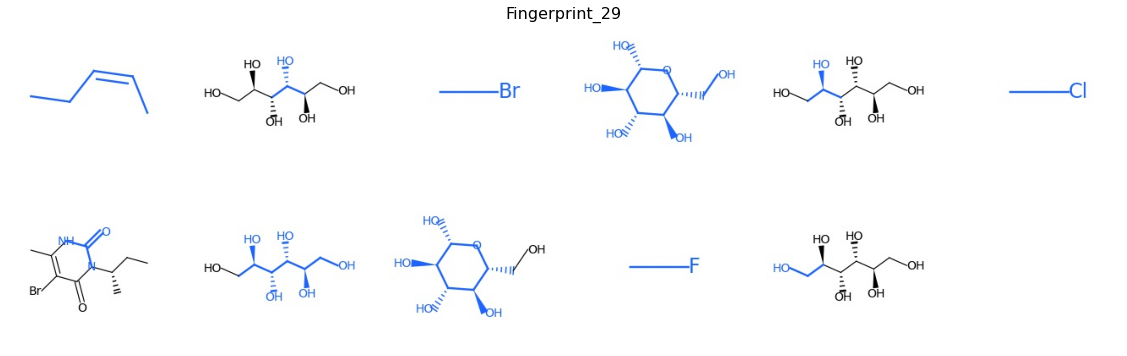

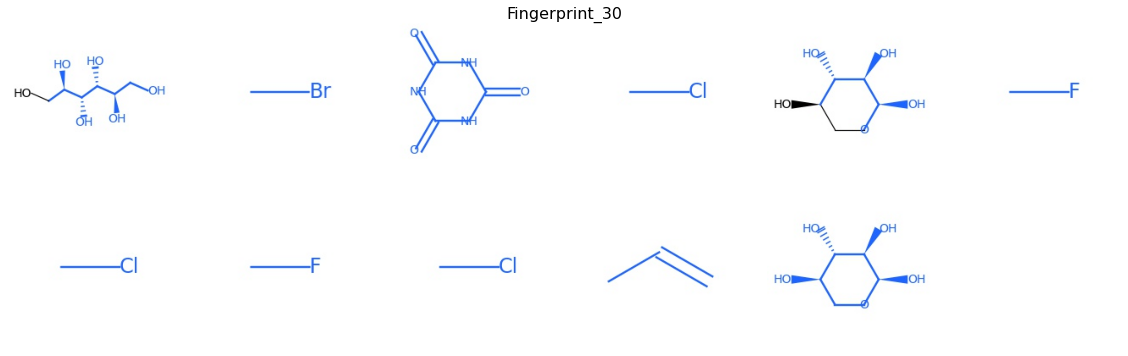

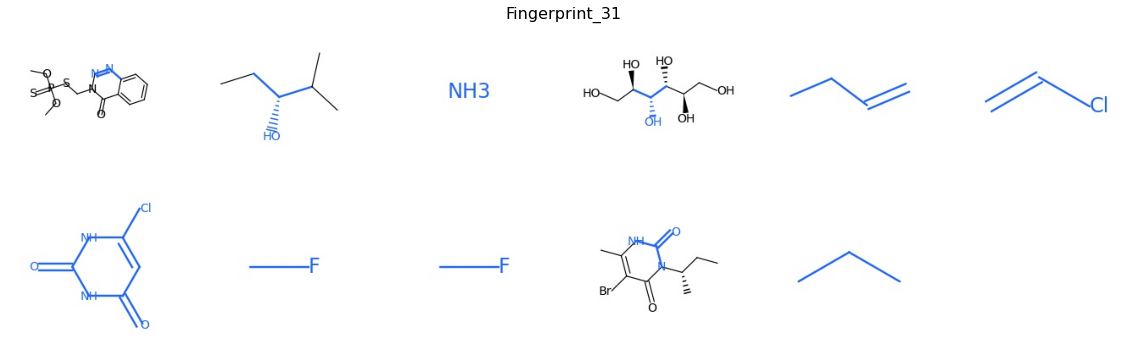

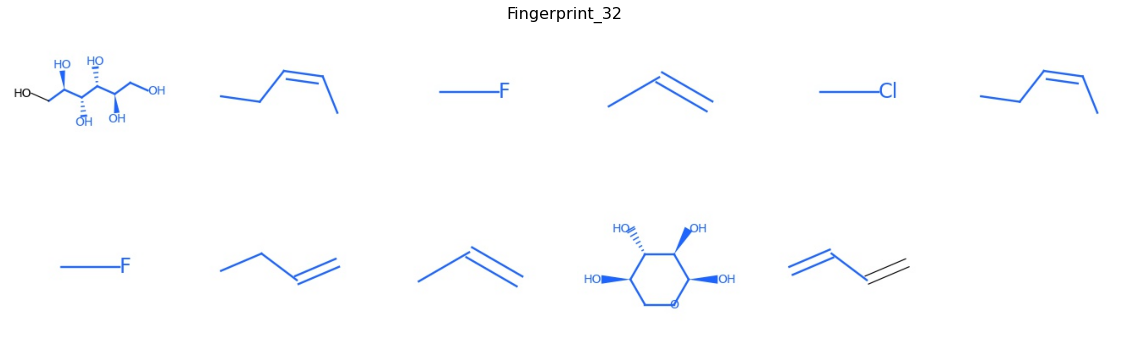

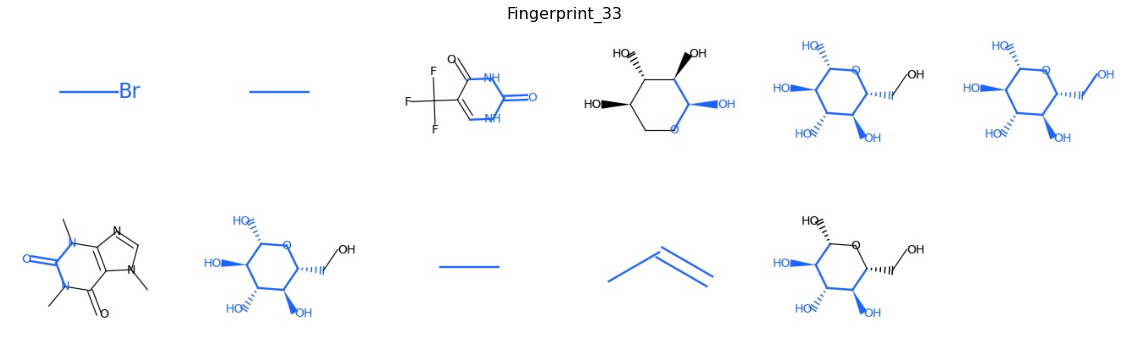

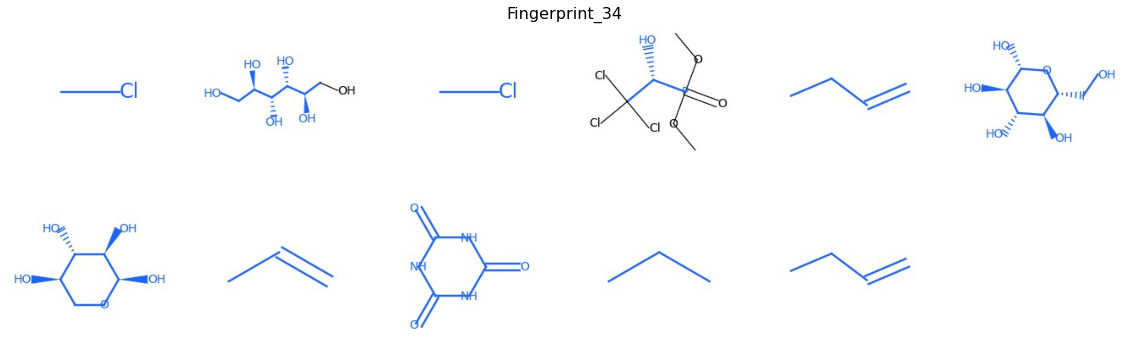

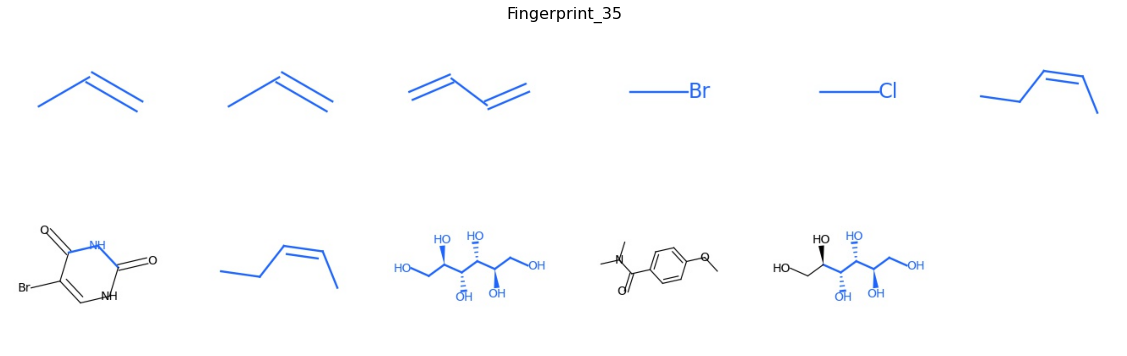

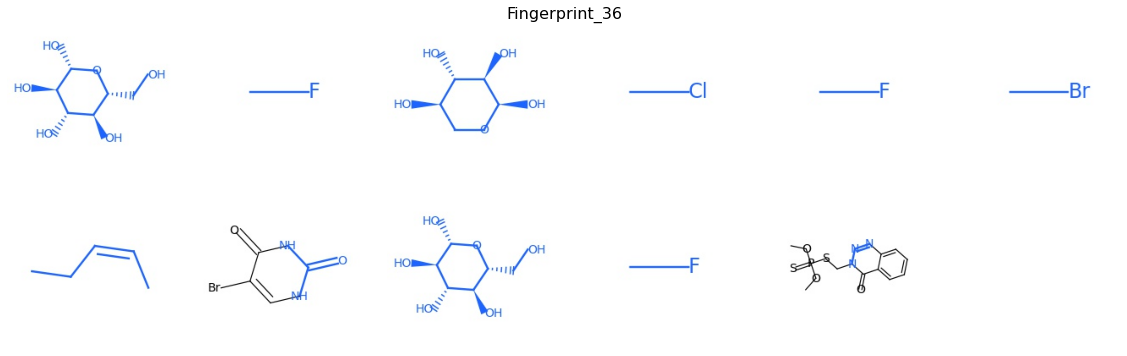

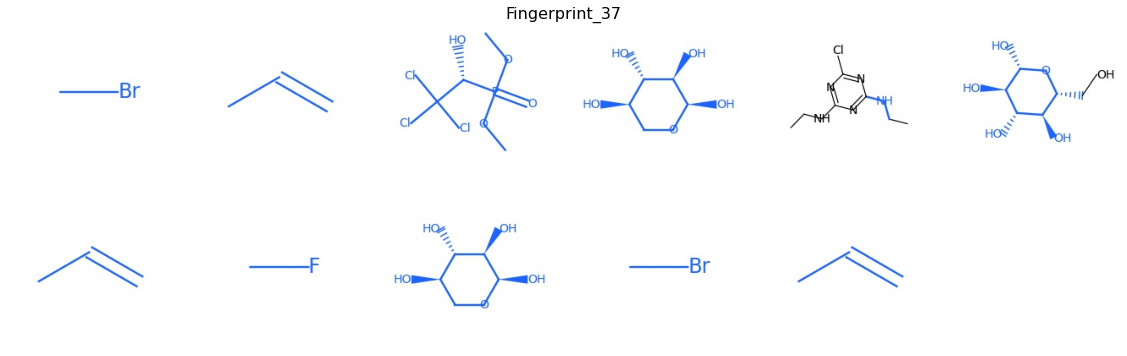

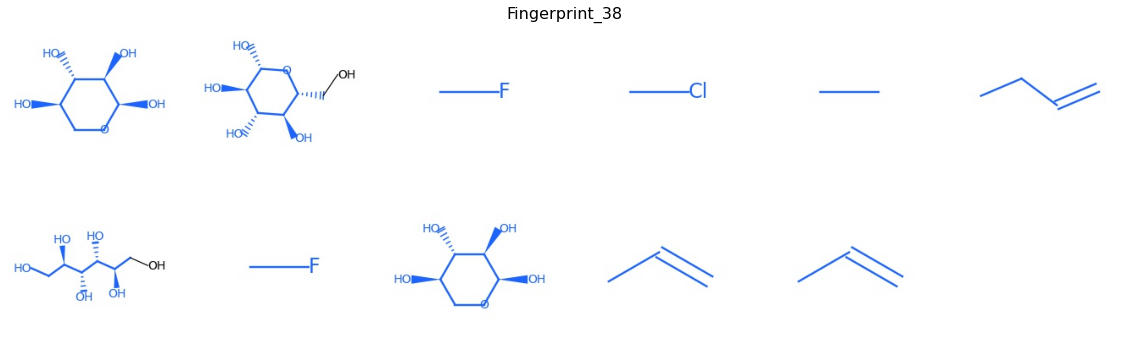

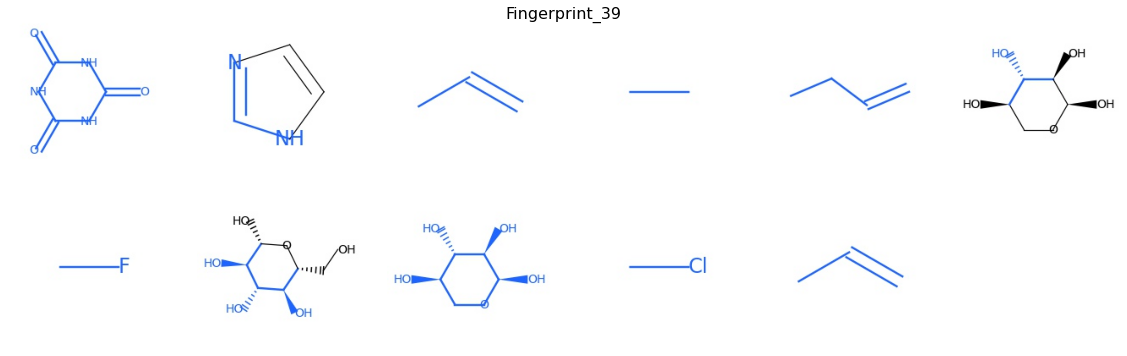

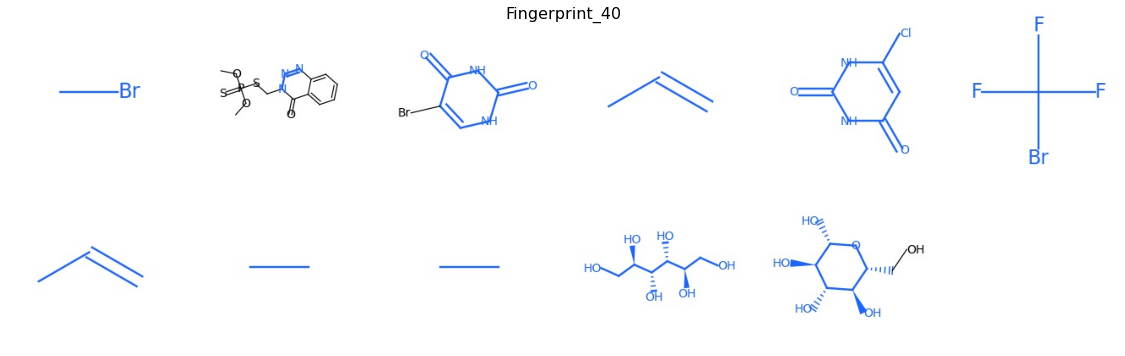

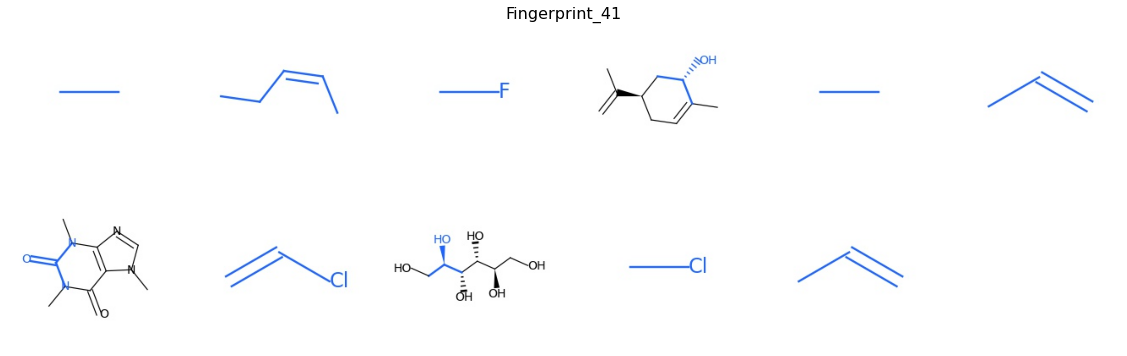

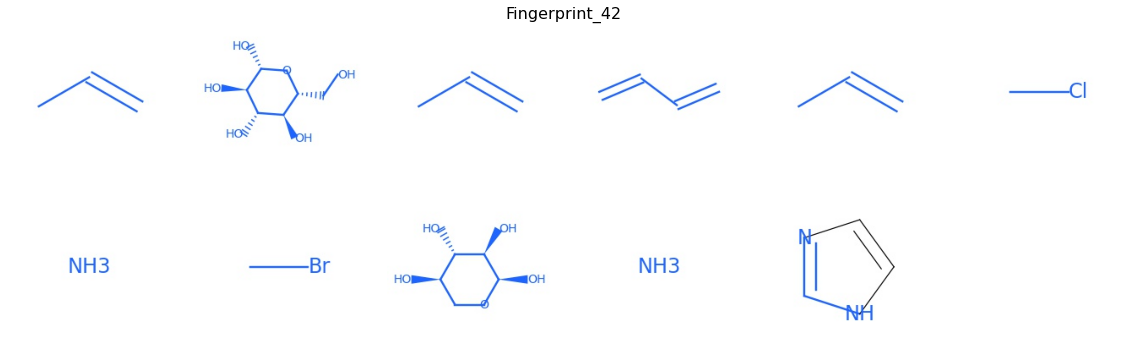

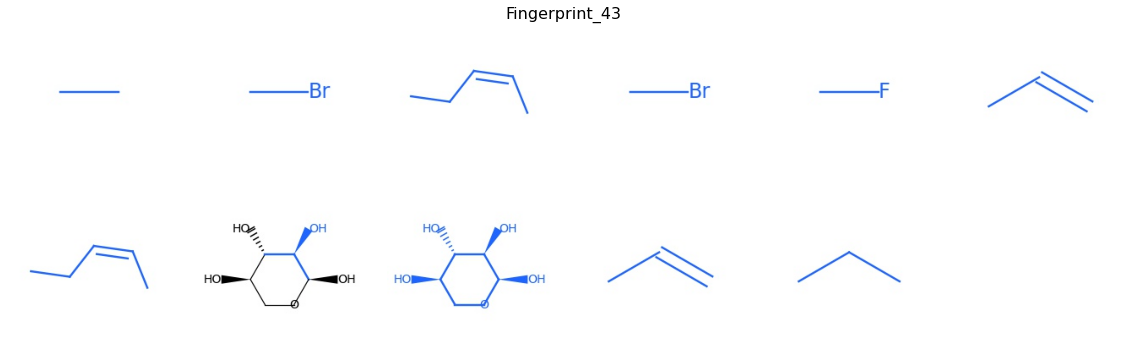

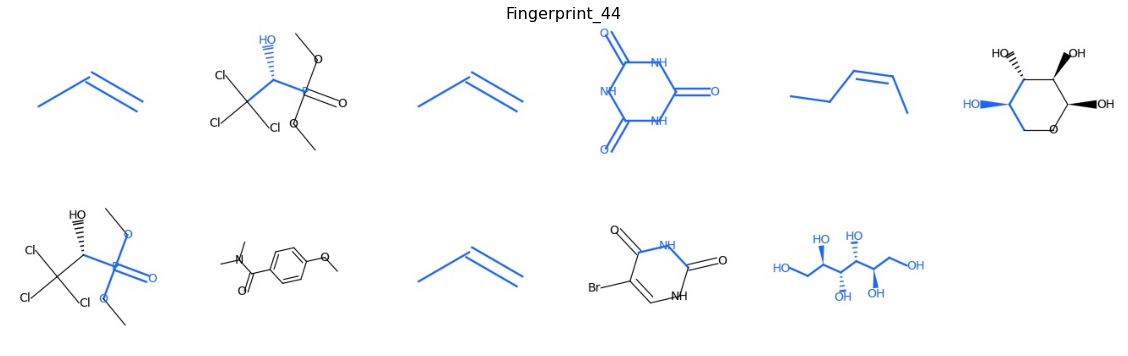

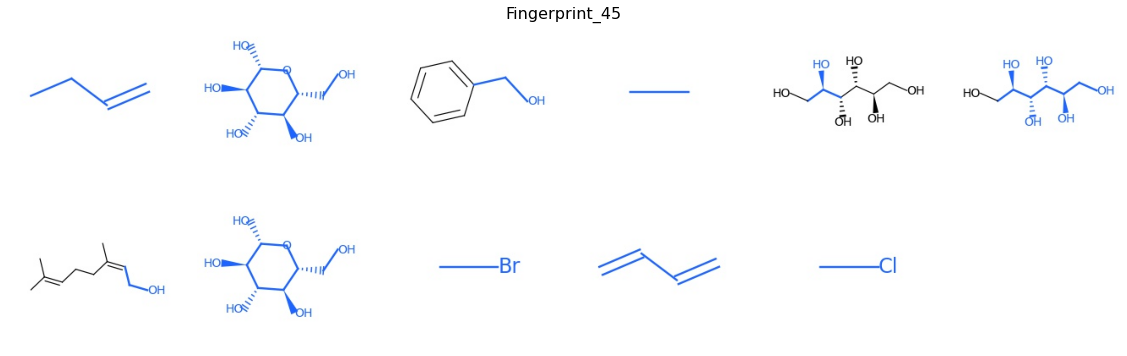

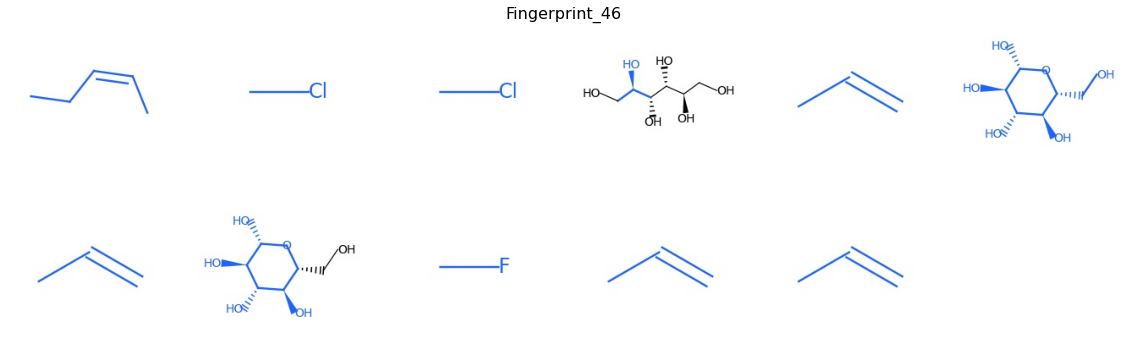

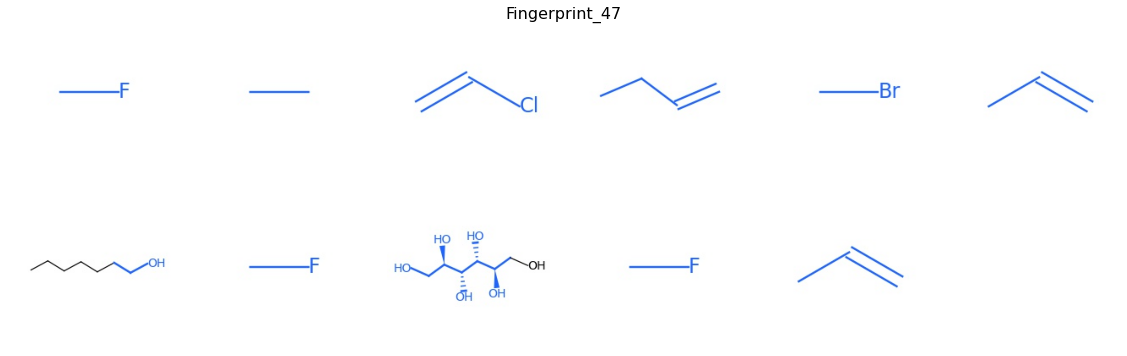

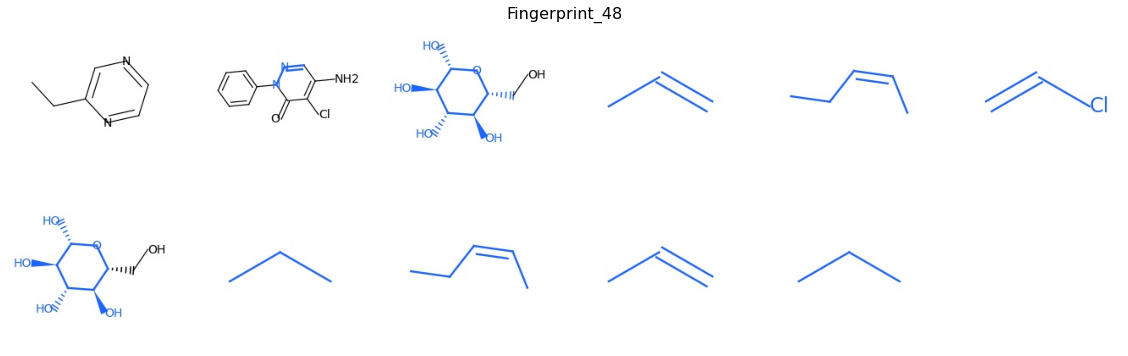

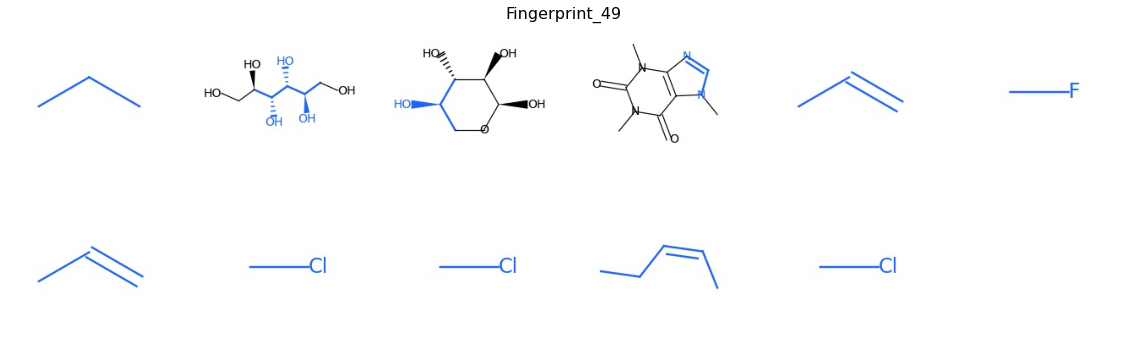

In [40]:
for FP in range(len(dataset)//11):
    visualize(FP)